In [2]:
# Goals
# - Predict views with just thumbnails and time since upload
# - Predict which of two thumbnails will do better
# - Predict views using everything
#
#
# Implementation steps:
# 1. Scrape data form YT videos
# 2. Scrape stats from channels
# 3. Download thumbnails
# 4. Download videos
# 5. Run a feature extractor over thumbnails
# 6. Run a feature extractor over videos (video and audio)
# 7. Create an EDA
# 8. Create a preprocessor and dataloader for all data
# 9. Create the regression model
# 10. Train the model
# 11. Test the model

In [123]:
import pickle
import warnings

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, random_split

from prepare_data import yt_label_to_datetime

DEVICE = 'cuda:0'

In [25]:
# Load the data
df = pd.read_csv('data/full_data.csv', parse_dates=['channel_scrape_date', 'scrape_date', 'date'])

# Read the pickle from "data/thumbnail_features.pkl"
with open('data/thumbnail_features.pkl', 'rb') as f:
    thumbnail_feature_idxs, thumbnail_features = pickle.load(f)
# Order the features according to the df ordering
tf_map = {i: f for i, f in zip(thumbnail_feature_idxs, thumbnail_features)}
thumbnail_features = np.array([tf_map[i] for i in df['feature_id']])

In [5]:
df.columns

Index(['feature_id', 'thumbnail_link', 'view_count', 'date', 'video_title',
       'video_description', 'subscriber_count', 'likes', 'scrape_date',
       'channel_name', 'channel_link', 'video_url', 'vid_page_titles',
       'vid_page_upload_date', 'vid_page_views', 'channel_scrape_date',
       'time_up'],
      dtype='object')

In [6]:
def reconstruct_list(list_str, convert_func):
    if list_str[-2] == ',':
        list_str = list_str[:-1]
    list_str = list_str[1:-1]

    return list(convert_func(x) for x in list_str.split(', '))

def reconstruct_str_list(list_str, convert_func):
    if list_str[-2] == ',':
        list_str = list_str[:-1]
    list_str = list_str[2:-2]

    return list(convert_func(x) if x != '' else None for x in list_str.split("', '"))

In [7]:
upload_dates = df.apply(
    lambda x: reconstruct_str_list(
            x['vid_page_upload_date'],
            convert_func=lambda y: yt_label_to_datetime(y, x['channel_scrape_date'])),
    axis=1)

vid_page_time_up = [[(sd - vd).total_seconds() if vd is not None else None for vd in vds] for vds, sd in zip(upload_dates, df['scrape_date'].values)]
MONTH_IN_SECONDS = 60 * 60 * 24 * 30
keep_mask = [[t is not None and (0 <= t <= MONTH_IN_SECONDS) for t in ts] \
    for ts in vid_page_time_up]

vid_page_views = df['vid_page_views'].apply(reconstruct_list, convert_func=int)

In [8]:
vid_page_views_std = vid_page_views.apply(lambda x: np.array(x).std())

In [9]:
vid_page_views_std

0        4.139572e+05
1        4.821486e+06
2        3.818782e+04
3        4.806163e+06
4        4.139572e+05
             ...     
16531    2.086159e+05
16532    1.485356e+06
16533    1.620850e+06
16534    1.550371e+06
16535    8.497391e+04
Name: vid_page_views, Length: 16536, dtype: float64

In [10]:
apply_2d_mask(vid_page_time_up, keep_mask)

NameError: name 'apply_2d_mask' is not defined

In [22]:
np.concatenate([np.array(x).reshape(-1) for x in df.iloc[0].values]).shape

(17,)

In [ ]:
# Features
# thumbnail_embeddings, log_time_up, video_title,
# video_description (truncated), log_subscriber_count,
# log avg views over the month, views log std over the month,
# num of videos in the last month

In [108]:
MONTH_IN_SECONDS = 60 * 60 * 24 * 30

def apply_2d_mask(list_2d, mask):
    return [[x for x, k in zip(l, m) if k] for l, m in zip(list_2d, mask)]

class VideoInfoDataset(Dataset):
    def __init__(self, ref_df, thumbnail_embeds):
        min_n_videos = 5
        self.thumbnail_embeds = thumbnail_embeds
        
        self.df = pd.DataFrame()
        self.df['thumbnail_embeds'] = list(thumbnail_embeds)
        self.df['log_view_count'] = np.log(ref_df['view_count'].values + 1)
        self.df['log_time_up'] = np.log(ref_df['time_up'].values + 1)
        self.df['log_subscriber_count'] = np.log(ref_df['subscriber_count'].values + 1)

        # Use the dates to determine which to keep
        upload_dates = ref_df.apply(
            lambda x: reconstruct_str_list(
                    x['vid_page_upload_date'],
                    convert_func=lambda y: yt_label_to_datetime(y, x['channel_scrape_date'])),
            axis=1)
        vid_page_time_up = [[(sd - vd).total_seconds() if vd is not None else None for vd in vds] \
            for vds, sd in zip(upload_dates, ref_df['scrape_date'].values)]
        keep_mask = [[t is not None and (0 <= t <= MONTH_IN_SECONDS) for t in ts] \
            for ts in vid_page_time_up]
        
        self.df['vid_page_views'] = ref_df['vid_page_views'].apply(reconstruct_list, convert_func=int)
        self.df['vid_page_views'] = apply_2d_mask(self.df['vid_page_views'], keep_mask)
        self.df['vid_page_log_views'] = self.df['vid_page_views'].apply(lambda x: [np.log(e + 1) for e in x])

        # Add more feature columns
        self.df['month_avg_log_views'] = self.df['vid_page_log_views'].apply(np.mean)
        self.df['month_std_log_views'] = self.df['vid_page_log_views'].apply(np.std)
        self.df['month_n_videos'] = self.df['vid_page_views'].apply(len)

        # Drop non-feature columns
        self.df.drop(['vid_page_views', 'vid_page_log_views'], axis=1, inplace=True)
        self.df = self.df[self.df['month_n_videos'] >= min_n_videos]

        self.scalers = None
        self.standardized = False

    def standardize(self, scalers=None):
        if self.standardized:
            warnings.warn('Dataset had already been standardized!')

        if scalers is None and self.scalers is None:
            scalers = {}
            for col in self.df.columns:
                scalers[col] = StandardScaler()
                if col == 'thumbnail_embeds':
                    scalers[col].fit(np.stack(self.df[col].values))
                else:
                    scalers[col].fit(self.df[col].values.reshape(-1, 1))
            self.scalers = scalers
        elif self.scalers:
            scalers = self.scalers

        for col in self.df.columns:
            if col == 'thumbnail_embeds':
                self.df[col] = scalers[col].transform(np.stack(self.df[col].values))
            else:
                self.df[col] = scalers[col].transform(self.df[col].values.reshape(-1, 1))
        self.standardized = True

    def get_scalers(self):
        return self.scalers

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        target = np.array(row['log_view_count'])
        row = row.drop('log_view_count')
        features = np.concatenate([np.array(x).reshape(-1) for x in row.values])
        return features, target

In [ ]:
class RegressionModel(nn.Module)

In [124]:
vi_datastet = VideoInfoDataset(df, thumbnail_features)

# Create dataloaders for training, validation, and test sets
train_size = int(0.8 * len(vi_datastet))
val_size = int(0.05 * len(vi_datastet))
test_size = len(vi_datastet) - train_size - val_size

train_dataset, val_dataset, test_dataset = \
    random_split(vi_datastet, [train_size, val_size, test_size])

C:\Users\ninja\.conda\envs\ml2\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\ninja\.conda\envs\ml2\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [125]:
# Parameters
n_epochs = 10
batch_size = 16
lr = 0.001
print_freq = 8

In [110]:
np.stack(ds.df['thumbnail_embeds'].values).shape

(12021, 2048)

In [111]:
ds.standardize()

In [121]:
next(iter(ds))

(array([-0.23857889, -0.46276288,  0.72708339, -0.32128662,  1.20306019,
         0.42109761]),
 array(-0.21136625))

In [62]:
ds.df[ds.df['month_n_videos'] >= 5]

,log_time_up,log_subscriber_count,month_avg_log_views,month_std_log_views,month_n_videos
0,12.059896,15.957927,10.972606,1.252298,24
1,16.694619,16.222456,15.695769,0.494305,6
4,12.059896,15.957927,10.972606,1.252298,24
5,13.851651,16.997722,10.911854,0.671872,23
7,17.817213,15.957927,10.972606,1.252298,24
...,...,...,...,...,...
16531,13.312655,15.490736,13.251888,0.334915,29
16532,18.110802,14.538217,14.482662,0.504680,13
16533,15.697476,16.791040,15.132463,0.375633,29
16534,12.465359,14.950134,14.521274,0.373907,14


In [24]:
X = torch.tensor(thumbnail_features, dtype=torch.float32)

y = np.log(df['view_count'].values)
y = torch.tensor(y, dtype=torch.float32)
y = y.view(-1, 1)

NameError: name 'torch' is not defined

In [7]:
from sklearn import datasets, linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
%matplotlib inline

In [10]:
n = int(1e6)
X_train, X_test, y_train, y_test = train_test_split(X[:n], y[:n], test_size=0.15)

In [11]:
scaler = StandardScaler()
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)

In [12]:
model = MLPRegressor()
model.fit(X_train, y_train)

C:\Users\ninja\.conda\envs\ml2\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLPRegressor()

In [13]:
preds = model.predict(X_test)

Mean squared error: 1.46
Coefficient of determination: -0.43


C:\Users\ninja\.conda\envs\ml2\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

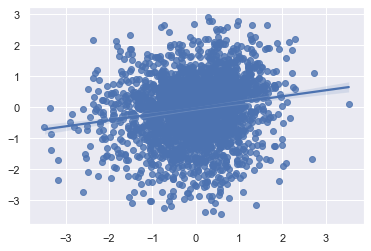

In [14]:
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, preds))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, preds))

# Plot outputs
sns.regplot(preds, y_test.reshape(-1))
# plt.plot(X_test, preds, color="blue", linewidth=3)

### Classifying the better of two thumbnails

In [16]:
X_ctrain = X_train
if len(X_ctrain) % 2 == 1:
    X_ctrain = X_ctrain[:-1]
X_ctrain = X_ctrain.view(X_ctrain.shape[0]//2, -1)

X_ctest = X_test
if len(X_ctest) % 2 == 1:
    X_ctest = X_ctest[:-1]
X_ctest = X_ctest.view(X_ctest.shape[0]//2, -1)

y_ctrain = y_train
if len(y_ctrain) % 2 == 1:
    y_ctrain = y_ctrain[:-1]
y_ctrain = y_ctrain.reshape(y_ctrain.shape[0]//2, -1)
y_ctrain = np.array([int(v1 > v2) for v1, v2 in y_ctrain])

y_ctest = y_test
if len(y_ctest) % 2 == 1:
    y_ctest = y_ctest[:-1]
y_ctest = y_ctest.reshape(y_ctest.shape[0]//2, -1)
y_ctest = np.array([int(v1 > v2) for v1, v2 in y_ctest])

In [17]:
print(X_train.shape, X_ctrain.shape)
print(y_train.shape, y_ctrain.shape)

print(X_test.shape, X_ctest.shape)
print(y_test.shape, y_ctest.shape)

torch.Size([14670, 2048]) torch.Size([7335, 4096])
(14670, 1) (7335,)
torch.Size([2589, 2048]) torch.Size([1294, 4096])
(2589, 1) (1294,)


In [28]:
ct_preds = model.predict(X_ctest.reshape(X_ctest.shape[0] * 2, -1))
ct_preds = ct_preds.reshape(X_ctest.shape[0], -1)
ct_preds = np.array([int(v1 > v2) for v1, v2 in ct_preds])

# Regression comparison accuracy
print('Regression Comparison Accuracy: {:.2f}%'.format(100 * accuracy_score(y_ctest, ct_preds)))

Regression Comparison Accuracy: 56.72%


In [90]:
# xscaler = StandardScaler()
# X_ctrain = xscaler.fit_transform(X_ctrain)
# X_ctest = xscaler.transform(X_ctest)

In [29]:
cmodel = MLPClassifier()
cmodel.fit(X_ctrain, y_ctrain.reshape(-1, 1))

C:\Users\ninja\.conda\envs\ml2\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninja\.conda\envs\ml2\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier()

In [30]:
cpreds = cmodel.predict(X_ctest)

In [31]:
y_ctest[:20], cpreds[:20]

(array([1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1]),
 array([1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0]))

In [32]:
print('Accuracy: {:.2f}%'.format(100 * accuracy_score(y_ctest, cpreds)))

Accuracy: 54.10%
